In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import plotly as py
import plotly.graph_objs as go

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
import sklearn.metrics

import time

# Kmeans Clustering

In [6]:
column_names = ["Sequence Name", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "Correct classification"]
pd.options.display.float_format = '{:,.2f}'.format

df = pd.read_fwf("yeast.data", sep="  ", names = column_names, on_bad_lines='skip') 

,0,1,2,3,4,5,6,7,8,9
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.50,0.00,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.50,0.00,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.50,0.00,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.50,0.00,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.50,0.00,0.48,0.22,MIT
...,...,...,...,...,...,...,...,...,...,...
1479,YUR1_YEAST,0.81,0.62,0.43,0.17,0.50,0.00,0.53,0.22,ME2
1480,ZIP1_YEAST,0.47,0.43,0.61,0.40,0.50,0.00,0.48,0.47,NUC
1481,ZNRP_YEAST,0.67,0.57,0.36,0.19,0.50,0.00,0.56,0.22,ME2
1482,ZUO1_YEAST,0.43,0.40,0.60,0.16,0.50,0.00,0.53,0.39,NUC


In [7]:
df.columns = column_names

In [8]:
#find number of null entries to see if there is a need to clean the dataset
df.isnull().sum()

Sequence Name             0
mcg                       0
gvh                       0
alm                       0
mit                       0
erl                       0
pox                       0
vac                       0
nuc                       0
Correct classification    0
dtype: int64

In [9]:
df.nunique()

Sequence Name             1462
mcg                         81
gvh                         79
alm                         53
mit                         78
erl                          2
pox                          3
vac                         48
nuc                         68
Correct classification      10
dtype: int64

In [10]:
num_clusters = df['Correct classification'].nunique()
num_clusters

10

In [11]:
df3 = df.iloc[:, [0,9]]
test_data = df3['Correct classification']
test_data

0       MIT
1       MIT
2       MIT
3       NUC
4       MIT
       ... 
1479    ME2
1480    NUC
1481    ME2
1482    NUC
1483    CYT
Name: Correct classification, Length: 1484, dtype: object

In [12]:
df = df.drop(df.columns[[0,9]],axis = 1)
df

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.61,0.47,0.13,0.50,0.00,0.48,0.22
1,0.43,0.67,0.48,0.27,0.50,0.00,0.53,0.22
2,0.64,0.62,0.49,0.15,0.50,0.00,0.53,0.22
3,0.58,0.44,0.57,0.13,0.50,0.00,0.54,0.22
4,0.42,0.44,0.48,0.54,0.50,0.00,0.48,0.22
...,...,...,...,...,...,...,...,...
1479,0.81,0.62,0.43,0.17,0.50,0.00,0.53,0.22
1480,0.47,0.43,0.61,0.40,0.50,0.00,0.48,0.47
1481,0.67,0.57,0.36,0.19,0.50,0.00,0.56,0.22
1482,0.43,0.40,0.60,0.16,0.50,0.00,0.53,0.39


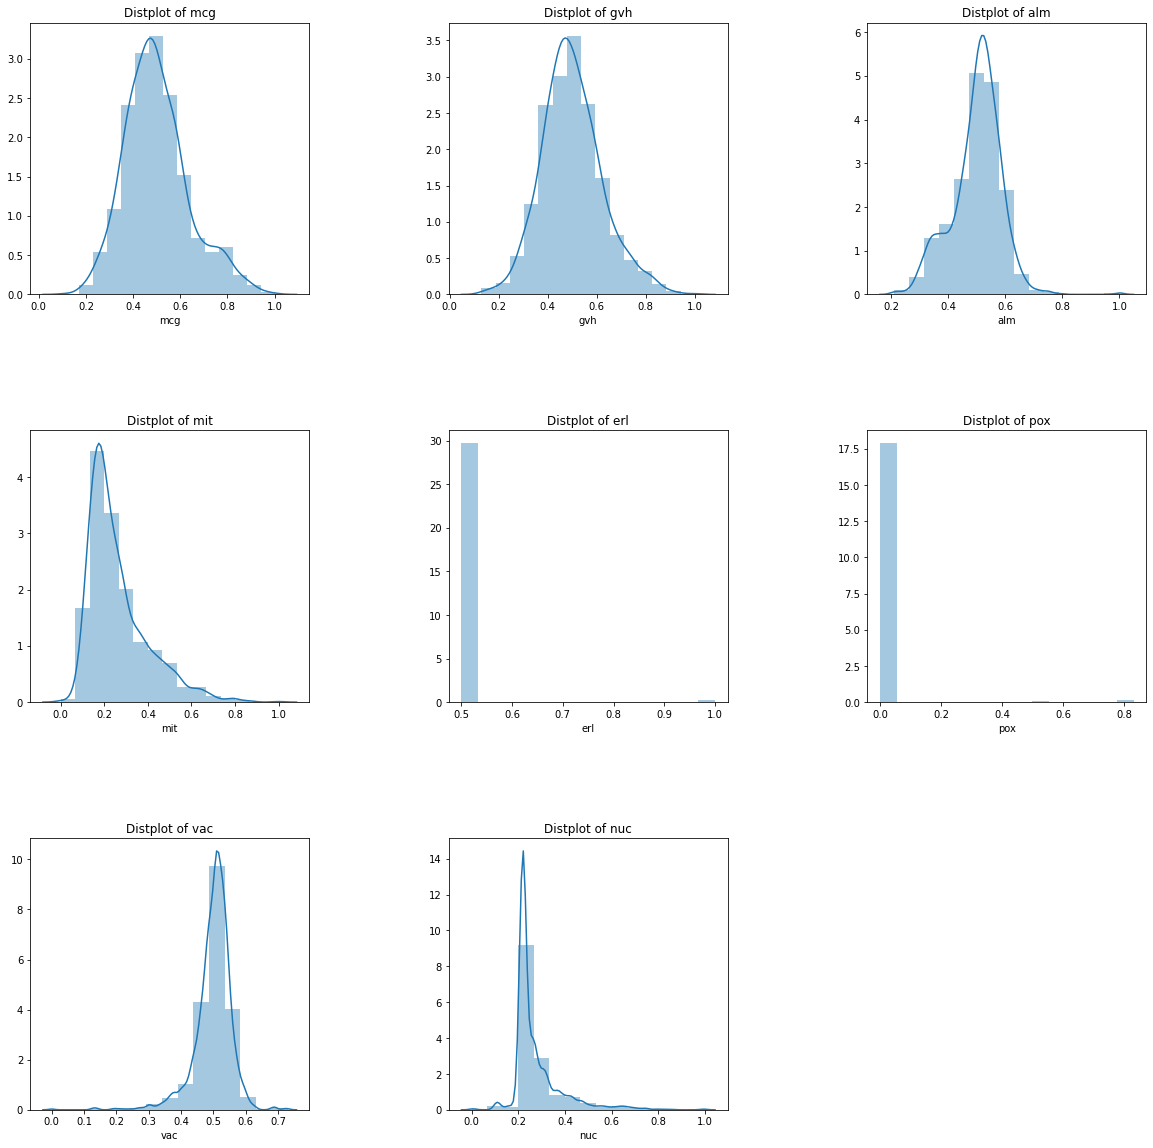

In [16]:
plt.figure(1 , figsize = (20 , 20))
n = 0 
float_column_names = ["mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc"]
for x in float_column_names:
    n += 1
    plt.subplot(3 , 3 , n)
    plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
    sns.distplot(df[x] , bins = 15)
    plt.title('Distplot of {}'.format(x))
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(df.values)
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
scaled_features_df

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.89,-0.35,-0.96,-0.10,-0.10,-0.34,-0.53
1,-0.51,1.37,-0.23,0.06,-0.10,-0.10,0.52,-0.53
2,1.02,0.97,-0.12,-0.81,-0.10,-0.10,0.52,-0.53
3,0.58,-0.48,0.81,-0.96,-0.10,-0.10,0.69,-0.53
4,-0.58,-0.48,-0.23,2.03,-0.10,-0.10,-0.34,-0.53
...,...,...,...,...,...,...,...,...
1479,2.26,0.97,-0.81,-0.67,-0.10,-0.10,0.52,-0.53
1480,-0.22,-0.56,1.27,1.01,-0.10,-0.10,-0.34,1.82
1481,1.24,0.57,-1.62,-0.52,-0.10,-0.10,1.04,-0.53
1482,-0.51,-0.81,1.15,-0.74,-0.10,-0.10,0.52,1.07


In [19]:
for_visual = scaled_features_df.copy()
scaled_features_df

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.89,-0.35,-0.96,-0.10,-0.10,-0.34,-0.53
1,-0.51,1.37,-0.23,0.06,-0.10,-0.10,0.52,-0.53
2,1.02,0.97,-0.12,-0.81,-0.10,-0.10,0.52,-0.53
3,0.58,-0.48,0.81,-0.96,-0.10,-0.10,0.69,-0.53
4,-0.58,-0.48,-0.23,2.03,-0.10,-0.10,-0.34,-0.53
...,...,...,...,...,...,...,...,...
1479,2.26,0.97,-0.81,-0.67,-0.10,-0.10,0.52,-0.53
1480,-0.22,-0.56,1.27,1.01,-0.10,-0.10,-0.34,1.82
1481,1.24,0.57,-1.62,-0.52,-0.10,-0.10,1.04,-0.53
1482,-0.51,-0.81,1.15,-0.74,-0.10,-0.10,0.52,1.07


In [20]:
# import PCA
from sklearn.decomposition import PCA 
# Applying PCA to visualize data
pca = PCA(n_components = 2)
pca_data_visual = pd.DataFrame(pca.fit_transform(scaled_features_df),columns=['PC1','PC2']) 
pca_data = pca_data_visual.copy()
pca_data

,PC1,PC2
0,0.87,-0.09
1,0.81,-0.16
2,1.28,-0.38
3,-0.23,-0.27
4,-0.18,1.27
...,...,...
1479,2.31,-0.45
1480,-1.11,0.48
1481,1.84,-1.18
1482,-1.46,-0.72


In [21]:
def kmeans_clustering(train_data, num_clusters, test_data):
    cluster_data = train_data.copy()
    kmeans = KMeans(n_clusters = num_clusters, random_state=42)
    kmeans.fit(train_data)
    #implement 3 other metrics here
    print('Classification Accuracy: ', classification_accuracy(cluster_data, kmeans.labels_, test_data))
    print('Davies Bouldin index: ', davies_bouldin(train_data, kmeans.labels_))
    print('Silhouetter Score: ', silhouette(train_data, kmeans.labels_))
    print('Calinski Harabasz Score: ', calinski_score(train_data, kmeans.labels_))

In [22]:
# train_data is the data we fit the clustering algorithm on (without the predict label and after all the cleaning, PCA, one_hot_encoding)
# predicted_clusters is the output we get from the clustering algorithm(eg:- kmeans.labels_)
# test_data is the predict label which we remove from the train_data

# train_data - DataFrame
# predicted_cluster - Series
# test_data - 

def classification_accuracy(train_data, predicted_clusters, test_data):
    actual_labels = test_data.value_counts().index.tolist()
    train_data['predicted_clusters'] = predicted_clusters
    cluster_labels = pd.value_counts(pd.Series(predicted_clusters))
    cluster_labels = np.stack([cluster_labels.keys().values, cluster_labels.values]).T
    cluster_labels = cluster_labels.tolist()
    for i in range(len(cluster_labels)):
        cluster_labels[i].append(actual_labels[i])
    cluster_labels.sort()
    train_data['predicted_labels'] = list(map(lambda x : cluster_labels[x][2], train_data['predicted_clusters']))
    sum(train_data['predicted_labels']==test_data)
    accuracy = sum(train_data['predicted_labels']==test_data)/len(test_data)
    return accuracy

def davies_bouldin(train_data, predicted_clusters):
    from sklearn.metrics import davies_bouldin_score
    return(davies_bouldin_score(train_data, predicted_clusters))

def silhouette(train_data, predicted_clusters):
    from sklearn.metrics import silhouette_score
    score = silhouette_score(train_data, predicted_clusters, metric='euclidean')
    return score

def calinski_score(train_data, predicted_clusters):
    from sklearn.metrics import calinski_harabasz_score
    return(calinski_harabasz_score(train_data, predicted_clusters))
#Example
#classification_accuracy(clustering_data, kmeans.labels_, test_data)

## Using the scaled data for kmeans

In [23]:
kmeans =KMeans(n_clusters=10,random_state=42).fit(for_visual)

In [24]:
kmeans_clustering(for_visual, num_clusters, test_data)

Classification Accuracy:  0.3106469002695418
Davies Bouldin index:  1.2359954697988556
Silhouetter Score:  0.18502129023412767
Calinski Harabasz Score:  317.07131149546655


In [25]:
labels = kmeans.fit_predict(scaled_features_df)
scaled_features_df['cluster'] = pd.DataFrame(labels)
scaled_features_df['cluster'].value_counts()

1    316
6    256
0    193
9    170
4    165
3    161
5    121
8     73
2     15
7     14
Name: cluster, dtype: int64

In [26]:
test_data.value_counts()

CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: Correct classification, dtype: int64

## Using the pca data for kmeans and visualization 

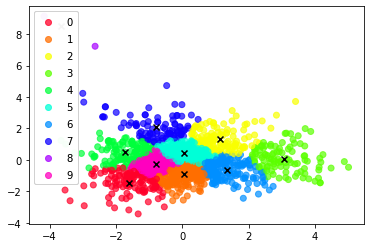

In [27]:
fig,ax = plt.subplots()
kmeans =KMeans(n_clusters=10,random_state=42).fit(pca_data)
pca_data_visual['cluster'] = pd.Categorical(kmeans.labels_)
scatter = ax.scatter(pca_data_visual['PC1'], pca_data_visual['PC2'],c=pca_data_visual['cluster'],cmap='gist_rainbow',alpha=0.7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="")
centers = np.array(kmeans.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='black')
ax.add_artist(legend1)

In [28]:
kmeans_clustering(pca_data, num_clusters, test_data)

Classification Accuracy:  0.1610512129380054
Davies Bouldin index:  0.8191275615709405
Silhouetter Score:  0.3068349938349531
Calinski Harabasz Score:  824.8002492634109


In [29]:
labels = kmeans.fit_predict(pca_data)
scaled_features_df['cluster'] = pd.DataFrame(labels)
scaled_features_df['cluster'].value_counts()

5    254
9    253
1    245
6    160
4    131
2    125
0    116
3    101
7     96
8      3
Name: cluster, dtype: int64

In [30]:
test_data.value_counts()

CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: Correct classification, dtype: int64

# Kmeans++ Clustering

In [31]:
scaled_features = StandardScaler().fit_transform(df.values)
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
scaled_features_df

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.89,-0.35,-0.96,-0.10,-0.10,-0.34,-0.53
1,-0.51,1.37,-0.23,0.06,-0.10,-0.10,0.52,-0.53
2,1.02,0.97,-0.12,-0.81,-0.10,-0.10,0.52,-0.53
3,0.58,-0.48,0.81,-0.96,-0.10,-0.10,0.69,-0.53
4,-0.58,-0.48,-0.23,2.03,-0.10,-0.10,-0.34,-0.53
...,...,...,...,...,...,...,...,...
1479,2.26,0.97,-0.81,-0.67,-0.10,-0.10,0.52,-0.53
1480,-0.22,-0.56,1.27,1.01,-0.10,-0.10,-0.34,1.82
1481,1.24,0.57,-1.62,-0.52,-0.10,-0.10,1.04,-0.53
1482,-0.51,-0.81,1.15,-0.74,-0.10,-0.10,0.52,1.07


In [34]:
for_visual = scaled_features_df.copy()
scaled_features_df

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.89,-0.35,-0.96,-0.10,-0.10,-0.34,-0.53
1,-0.51,1.37,-0.23,0.06,-0.10,-0.10,0.52,-0.53
2,1.02,0.97,-0.12,-0.81,-0.10,-0.10,0.52,-0.53
3,0.58,-0.48,0.81,-0.96,-0.10,-0.10,0.69,-0.53
4,-0.58,-0.48,-0.23,2.03,-0.10,-0.10,-0.34,-0.53
...,...,...,...,...,...,...,...,...
1479,2.26,0.97,-0.81,-0.67,-0.10,-0.10,0.52,-0.53
1480,-0.22,-0.56,1.27,1.01,-0.10,-0.10,-0.34,1.82
1481,1.24,0.57,-1.62,-0.52,-0.10,-0.10,1.04,-0.53
1482,-0.51,-0.81,1.15,-0.74,-0.10,-0.10,0.52,1.07


In [35]:
pca = PCA(n_components = 2)
pca_data_visual = pd.DataFrame(pca.fit_transform(scaled_features_df),columns=['PC1','PC2']) 
pca_data = pca_data_visual.copy()
pca_data

,PC1,PC2
0,0.87,-0.09
1,0.81,-0.16
2,1.28,-0.38
3,-0.23,-0.27
4,-0.18,1.27
...,...,...
1479,2.31,-0.45
1480,-1.11,0.48
1481,1.84,-1.18
1482,-1.46,-0.72


In [36]:
def plus_plus(ds, k, random_state=42):
    np.random.seed(42)
    centroids = [ds[0]]

    for _ in range(1, k):
        dist_sq = np.array([min([np.inner(c-x,c-x) for c in centroids]) for x in ds])
        probs = dist_sq/dist_sq.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        
        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break
        
        centroids.append(ds[i])

    return np.array(centroids)

In [37]:
ds_scaled = for_visual.to_numpy()

In [38]:
ds_pca = pca_data.to_numpy()

In [39]:
ds_scaled

array([[ 0.58198136,  0.88848148, -0.3466451 , ..., -0.0991314 ,
        -0.34417514, -0.5279193 ],
       [-0.51089067,  1.37281104, -0.23122636, ..., -0.0991314 ,
         0.52121948, -0.5279193 ],
       [ 1.01913017,  0.96920307, -0.11580762, ..., -0.0991314 ,
         0.52121948, -0.5279193 ],
       ...,
       [ 1.23770457,  0.5655951 , -1.61625127, ..., -0.0991314 ,
         1.04045625, -0.5279193 ],
       [-0.51089067, -0.80667199,  1.15379854, ..., -0.0991314 ,
         0.52121948,  1.06900494],
       [ 1.0919883 ,  0.32343032,  0.46128609, ..., -0.0991314 ,
         0.52121948, -0.5279193 ]])

In [40]:
ds_pca

array([[ 0.87233638, -0.09422448],
       [ 0.8134819 , -0.16052259],
       [ 1.28311478, -0.37504888],
       ...,
       [ 1.83867302, -1.18163864],
       [-1.46303883, -0.71536005],
       [ 0.6856017 , -0.21475233]])

In [41]:
centroids_scaled = plus_plus(ds_scaled, num_clusters)

In [42]:
centroids_pca = plus_plus(ds_pca, num_clusters)

In [43]:
def kmeans_clustering_plus(train_data, num_centroids, num_clusters, test_data):
    cluster_data = train_data.copy()
    kmeans = KMeans(n_clusters = num_clusters, init = num_centroids, random_state=42)
    kmeans.fit(train_data)
    #implement 3 other metrics here
    print('Classification Accuracy: ', classification_accuracy(cluster_data, kmeans.labels_, test_data))
    print('Davies Bouldin index: ', davies_bouldin(train_data, kmeans.labels_))
    print('Silhouetter Score: ', silhouette(train_data, kmeans.labels_))
    print('Calinski Harabasz Score: ', calinski_score(train_data, kmeans.labels_))

## Using the scaled data for kmeans++ 

In [44]:
kmeans =KMeans(n_clusters=num_clusters, init = centroids_scaled ,random_state=42).fit(for_visual)

In [45]:
kmeans_clustering_plus(for_visual, centroids_scaled, num_clusters, test_data)

Classification Accuracy:  0.23450134770889489
Davies Bouldin index:  1.2623353164431619
Silhouetter Score:  0.18234279202698533
Calinski Harabasz Score:  316.8858092449157


In [46]:
labels = kmeans.fit_predict(scaled_features_df)
scaled_features_df['cluster'] = pd.DataFrame(labels)
scaled_features_df['cluster'].value_counts()

0    301
8    254
1    200
9    192
2    161
6    153
4    121
5     73
7     15
3     14
Name: cluster, dtype: int64

In [47]:
test_data.value_counts()

CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: Correct classification, dtype: int64

## Using the pca data for kmeans++ and visualization 

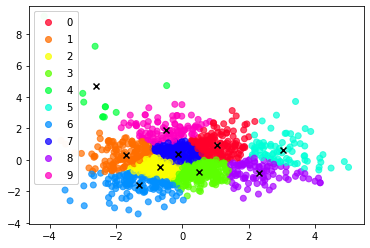

In [48]:
fig,ax = plt.subplots()
kmeans =KMeans(n_clusters=num_clusters, init = centroids_pca ,random_state=42).fit(pca_data)
pca_data_visual['cluster'] = pd.Categorical(kmeans.labels_)
scatter = ax.scatter(pca_data_visual['PC1'], pca_data_visual['PC2'],c=pca_data_visual['cluster'],cmap='gist_rainbow',alpha=0.7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="")
centers = np.array(kmeans.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='black')
ax.add_artist(legend1)

In [49]:
kmeans_clustering_plus(pca_data, centroids_pca, num_clusters, test_data)

Classification Accuracy:  0.16576819407008087
Davies Bouldin index:  0.9071434594106569
Silhouetter Score:  0.30938703934711553
Calinski Harabasz Score:  785.5766943896001


In [50]:
labels = kmeans.fit_predict(pca_data)
pca_data['cluster'] = pd.DataFrame(labels)
pca_data['cluster'].value_counts()

3    267
2    260
7    229
1    161
0    159
6    129
9    102
8     89
5     76
4     12
Name: cluster, dtype: int64

In [51]:
test_data.value_counts()

CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: Correct classification, dtype: int64